In [1]:
#Imports
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt #for making figures
%matplotlib inline

In [2]:
#Read in all the words
words = open('../data/names.txt').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
#Build stoi and itos lookup tables
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# Build train, dev, and test datasets
block_size = 3

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] #crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random 
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [17]:
#Utility function for comparing manual gradients with pytorch gradients
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [6]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(6789998212) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
#Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.1 # using bl just for fun, it's useless because of batchnorm
#Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating mant of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total 
for p in parameters:
    p.requires_grad = True

4137


In [7]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

In [ ]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time
emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
#Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
#Batchnorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
#Nonlinearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()
# PyTorch backward pass
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, norm_logits, logit_maxes, logits, h, hpreact, bnraw, bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani, embcat, emb]:
    t.retain_grad()
loss.backward()
loss

tensor(3.4156, grad_fn=<NegBackward0>)

In [148]:
counts.shape

torch.Size([32, 27])

In [149]:
norm_logits.shape

torch.Size([32, 27])

In [150]:
logits.shape

torch.Size([32, 27])

In [ ]:
log(exp(logits_ij - max(logits_ij)) / sum_j exp(logits_ij - max(logits_ij)))

### Manual Backprop

When we say `d<tensor>`, we mean the approximate gradient of the loss with repect to each element of that tensor at a given point (example).

Since the loss is scalar valued, the approximate gradients should be tensors of the same shapes as the originals. **It really helps to start by looking at all the shapes of the subequation in question**

In [ ]:
Xb[:5]

tensor([[ 0,  0, 10],
        [ 0, 20, 18],
        [ 0,  0,  1],
        [ 1, 18, 25],
        [ 0, 14,  9]])

In [145]:
demb[:5]

tensor([[[-1.5794e-03, -3.0237e-03, -4.3794e-04, -9.2916e-03, -5.9909e-03,
           4.5000e-03, -8.6678e-04, -2.1318e-03, -2.5644e-03,  1.4907e-03],
         [-5.9990e-04,  1.0431e-02,  9.3414e-03,  4.9726e-03,  3.3711e-03,
           2.4713e-03, -2.4440e-03,  1.7875e-03,  2.5357e-03,  7.3267e-04],
         [-2.4551e-03,  2.7485e-03,  3.0188e-03,  5.4786e-03, -5.1199e-03,
          -6.9041e-05, -2.8089e-03, -2.7815e-03,  5.2028e-03,  8.3906e-03]],

        [[ 8.9329e-03, -2.6615e-04,  3.3766e-03, -1.4389e-03, -2.4813e-04,
           7.0819e-03,  1.2858e-03,  1.2795e-03, -2.4350e-04,  1.2195e-03],
         [-2.5353e-04,  4.6974e-04, -3.9158e-04,  4.3373e-03, -4.0750e-04,
          -2.2942e-03, -1.7822e-03,  3.5704e-03, -4.0914e-03, -2.3065e-03],
         [-2.8375e-03,  2.0002e-03, -1.5089e-03,  3.7345e-03,  8.5535e-04,
           4.4042e-05, -3.8624e-04,  1.2566e-03,  1.0535e-03, -9.6751e-05]],

        [[-1.4704e-03,  4.9175e-03, -5.9619e-03, -1.9446e-04, -9.8715e-04,
           4.64

In [146]:
# emb = C[Xb]
emb.shape, C.shape, Xb.shape[0]

(torch.Size([32, 3, 10]), torch.Size([27, 10]), 32)

In [ ]:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
cmp('dlogprobs', dlogprobs, logprobs)

dprobs = probs**-1 * dlogprobs
cmp('dprobs', dprobs, probs)

#!!! Since `counts_sum_inv` is broadcast into `counts`, we must sum across the broadcast dimension
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
cmp('dcounts_sum_inv', dcounts_sum_inv, counts_sum_inv)

dcounts_sum = - counts_sum**-2 * dcounts_sum_inv
cmp('dcounts_sum', dcounts_sum, counts_sum)

dcounts = counts_sum_inv * dprobs + torch.ones_like(counts) * dcounts_sum
cmp('dcounts', dcounts, counts)

dnorm_logits = norm_logits.exp() * dcounts
cmp('dnorm_logits', dnorm_logits, norm_logits)

dlogit_maxes = - dnorm_logits.sum(1, keepdim=True)
cmp('dlogit_maxes', dlogit_maxes, logit_maxes)

#the derivative of max_j(x_ij) should be 1 if x_ij is the maximum, 0 otherwise
dlogits = dnorm_logits + (logits == logits.max(1, keepdim=True).values).float() * dlogit_maxes
cmp('dlogits', dlogits, logits)

#d/dx_ij(x_ij * \sum_k w_jk) * dlogits_ik
dh = dlogits @ W2.transpose(0,1)
cmp('dh', dh, h)

dW2 = h.transpose(0,1) @ dlogits
cmp('dW2', dW2, W2)

db2 = dlogits.sum(0)
cmp('db2', db2, b2)

#Recall that dtanh(x) = 1 - tanh^2(x) b/c tanh^2 + sech^2 = 1
dhpreact = (torch.ones_like(h) - h**2) * dh
cmp('dhpreact', dhpreact, hpreact)

dbngain = (bnraw*dhpreact).sum(0, keepdim=True)
cmp('dbngain', dbngain, bngain)

dbnbias = dhpreact.sum(0, keepdim=True) 
cmp('dbnbias', dbnbias, bnbias)

dbnraw = bngain * dhpreact
cmp('dbnraw', dbnraw, bnraw)

dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
cmp('dbnvar_inv', dbnvar_inv, bnvar_inv)

dbnvar = -0.5 * (bnvar + 1e-5)**-1.5 *dbnvar_inv
cmp('dbnvar', dbnvar, bnvar)

dbndiff2 = 1.0/(n-1) * torch.ones_like(bndiff2) * dbnvar
cmp('dbndiff2', dbndiff2, bndiff2)

dbndiff = bnvar_inv * dbnraw + 2 * bndiff * dbndiff2
cmp('dbndiff', dbndiff, bndiff)

dbnmeani = -dbndiff.sum(0, keepdim=True)
cmp('dbnmeani', dbnmeani, bnmeani)

dhprebn = dbndiff + 1.0/n * torch.ones_like(hprebn) * dbnmeani
cmp('dhprebn', dhprebn, hprebn)

dembcat = dhprebn @ W1.transpose(0,1)
cmp('dembcat', dembcat, embcat)

dW1 = embcat.transpose(0,1) @ dhprebn
cmp('dW1', dW1, W1)

db1 = dhprebn.sum(0)
cmp('db1', db1, b1)

#!!! Just as we cast forward, we can cast back. They're the same numbers.
demb = dembcat.view(emb.shape)
cmp('demb', demb, emb)

#C maps characters to 10dim vectors.
#in dC We want to accumulate gradients for the examples that mapped through C
dC = torch.zeros_like(C)
for i in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        l = Xb[i,j]
        dC[l,:] += demb[i,j,:]
cmp('dC', dC, C)

dlogprobs       | exact: True  | approximate: True  | maxdiff: 0.0
dprobs          | exact: True  | approximate: True  | maxdiff: 0.0
dcounts_sum_inv | exact: True  | approximate: True  | maxdiff: 0.0
dcounts_sum     | exact: True  | approximate: True  | maxdiff: 0.0
dcounts         | exact: True  | approximate: True  | maxdiff: 0.0
dnorm_logits    | exact: True  | approximate: True  | maxdiff: 0.0
dlogit_maxes    | exact: True  | approximate: True  | maxdiff: 0.0
dlogits         | exact: True  | approximate: True  | maxdiff: 0.0
dh              | exact: True  | approximate: True  | maxdiff: 0.0
dW2             | exact: True  | approximate: True  | maxdiff: 0.0
db2             | exact: True  | approximate: True  | maxdiff: 0.0
dhpreact        | exact: True  | approximate: True  | maxdiff: 0.0
dbngain         | exact: True  | approximate: True  | maxdiff: 0.0
dbnbias         | exact: True  | approximate: True  | maxdiff: 0.0
dbnraw          | exact: True  | approximate: True  | maxdiff:

### Backprop through cross-entropy in one go

In [151]:
logits.shape

torch.Size([32, 27])

In [152]:
dlogits = F.softmax(logits,1)
dlogits[range(n),Yb] -= 1
dlogits /= n
cmp('dlogits',dlogits, logits)

dlogits         | exact: False | approximate: True  | maxdiff: 5.587935447692871e-09


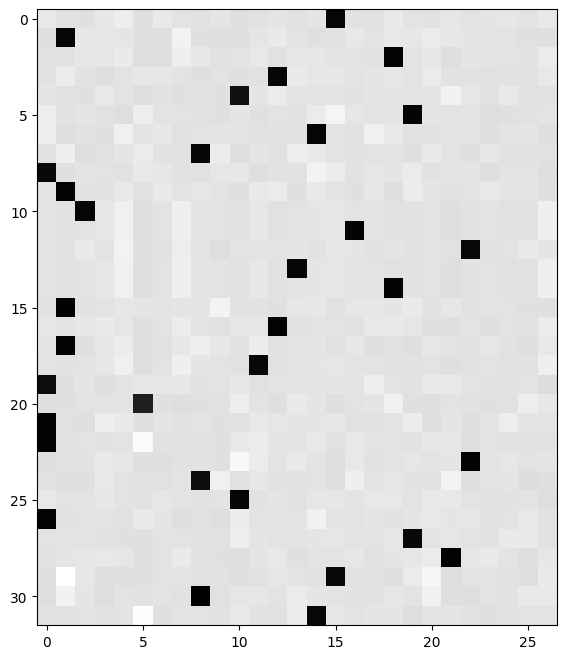

In [153]:
plt. figure(figsize=(8, 8))
plt. imshow(dlogits.detach(), cmap='gray')

### Backprop through batchnorm in one go

In [ ]:
#Batchnorm layer
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

In [160]:
hprebn.shape, bngain.shape, bnvar_inv.shape, dhpreact.shape, bnraw.shape

(torch.Size([32, 64]),
 torch.Size([1, 64]),
 torch.Size([1, 64]),
 torch.Size([32, 64]),
 torch.Size([32, 64]))

In [175]:
dhprebn = bngain*bnvar_inv/n*(n*dhpreact-dhpreact.sum(0,keepdim=True)-n/(n-1)*bnraw*(dhpreact*bnraw).sum(0,keepdim=True))
cmp('dhprebn', dhprebn, hprebn)

dhprebn         | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


### Putting it all together

In [184]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

  # kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
      p.grad = None
    # loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    # YOUR CODE HERE :)
    dlogits = F.softmax(logits,1)
    dlogits[range(n),Yb] -= 1
    dlogits /= n
    dh = dlogits @ W2.transpose(0,1)
    dW2 = h.transpose(0,1) @ dlogits
    db2 = dlogits.sum(0)
    dhpreact = (torch.ones_like(h) - h**2) * dh
    dbngain = (bnraw*dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True) 
    dhprebn = bngain*bnvar_inv/n*(n*dhpreact-dhpreact.sum(0,keepdim=True)-n/(n-1)*bnraw*(dhpreact*bnraw).sum(0,keepdim=True))
    dembcat = dhprebn @ W1.transpose(0,1)
    dW1 = embcat.transpose(0,1) @ dhprebn
    db1 = dhprebn.sum(0)
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
        for j in range(Xb.shape[1]):
            l = Xb[k,j]
            dC[l,:] += demb[k,j,:]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      # p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    # if i >= 100: # TODO: delete early breaking when you're ready to train the full net
    #   break

12297
      0/ 200000: 3.7935
  10000/ 200000: 2.1656
  20000/ 200000: 2.3807
  30000/ 200000: 2.4664
  40000/ 200000: 1.9587
  50000/ 200000: 2.3940
  60000/ 200000: 2.4531
  70000/ 200000: 2.1009
  80000/ 200000: 2.3489
  90000/ 200000: 2.1223
 100000/ 200000: 1.9489
 110000/ 200000: 2.3773
 120000/ 200000: 2.1013
 130000/ 200000: 2.4931
 140000/ 200000: 2.3178
 150000/ 200000: 2.1850
 160000/ 200000: 1.9274
 170000/ 200000: 1.8536
 180000/ 200000: 1.9549
 190000/ 200000: 1.8884


In [183]:
# useful for checking your gradients
for p,g in zip(parameters, grads):
  cmp(str(tuple(p.shape)), g, p)

(27, 10)        | exact: False | approximate: True  | maxdiff: 1.1175870895385742e-08
(30, 200)       | exact: False | approximate: True  | maxdiff: 8.381903171539307e-09
(200,)          | exact: False | approximate: True  | maxdiff: 5.587935447692871e-09
(200, 27)       | exact: False | approximate: True  | maxdiff: 1.4901161193847656e-08
(27,)           | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 2.7939677238464355e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09


In [185]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [186]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0707738399505615
val 2.109168291091919


In [187]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass
      emb = C[torch.tensor([context])] # (1,block_size,d)      
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmahza.
jahmari.
jari.
reet.
khalaysie.
mahnen.
delynn.
jareei.
ner.
kea.
chaiiv.
kaleigh.
ham.
join.
quint.
salin.
alianni.
waverogiearyxia.
kaellinsley.
dae.
